In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=554dd9c769c9f76b0e28869c6fb1bef60b1a70bbddb4a628ceceba51b243afbc
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=949df65086217252034c8f303fa999fa8ba40c9328f153659927db8bc0032f2a
  Stored in directory: /root/.cache/pip/w

In [20]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import argparse
import os
import copy
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
import cv2
import timm
import random
from torch.utils.data import WeightedRandomSampler

LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}

mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(224,224)),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize,
])

In [15]:
class OCTDataset(Dataset):
    def __init__(self, annot=None, unique_pairs=None, subset='train', transform=None, device='cpu'):
        if subset == 'train':
            self.annot = pd.read_csv("/content/drive/MyDrive/FML_Project/df_prime_train.csv")                      
        elif subset == 'val':
            self.annot = pd.read_csv("/content/drive/MyDrive/FML_Project/df_prime_train.csv")
            self.unique_pairs = unique_pairs
        elif subset == 'test':
            self.annot = pd.read_csv("/content/drive/MyDrive/FML_Project/df_prime_test.csv")

        # Extract "Patient_ID" and "Week_Num" columns
        self.patient_ids = self.annot["Patient_ID"]
        self.week_nums = self.annot["Week_Num"]
        self.patient_ids = self.annot["Patient_ID"]
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)]
        self.drss_class = self.annot['Severity_Label']

        if subset == 'train':
          # Create unique pairs of values
          self.unique_pairs = set(zip(self.patient_ids, self.week_nums, self.drss_class))

          # Create a list from the set of unique_pairs
          unique_pairs_list = list(self.unique_pairs)

          # Shuffle the unique_pairs_list
          random.shuffle(unique_pairs_list)

          # Calculate the index at which to split the list
          split_index = int(0.8 * len(unique_pairs_list))

          # Split the list into training and validation pairs
          self.unique_pairs = unique_pairs_list[:split_index]
          self.unique_validation_pairs = unique_pairs_list[split_index:]

        elif subset == 'test':
          # Create unique pairs of values
          self.unique_pairs = set(zip(self.patient_ids, self.week_nums, self.drss_class))

        self.root = os.path.expanduser("/content/drive/MyDrive/FML_Project/")
        self.transform = transform
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values

        self._labels = [pair[2] for pair in self.unique_pairs]
        assert len(self.unique_pairs) == len(self._labels)
        
        max_samples = int(len(self._labels))
        self.max_samples = max_samples
        self.device = device
        
    def __getitem__(self, index):
        # Get the Patient_ID and Week_Num from the indexed element in unique_pairs
        patient_id, week_num, target = list(self.unique_pairs)[index]

        # Filter the annot DataFrame to select rows that match the Patient_ID and Week_Num
        filtered_df = self.annot[(self.annot['Patient_ID'] == patient_id) & (self.annot['Week_Num'] == week_num)]

        # Extract the file paths from the filtered DataFrame and return them as a list
        file_paths = [self.root + file_path for file_path in filtered_df['File_Path'].values.tolist()]
        # Canny edge of each image blended together
        fused_image_path = os.path.dirname(file_paths[0])+"/cn_final.jpg"
        # Canny edge of each image formed as a grid
        # fused_image_path = os.path.dirname(file_paths[0])+"/grid_image_canny.jpg"
        # OCT images formed as a grid
        # fused_image_path = os.path.dirname(file_paths[0])+"/grid_image.jpg"
        # Canny edge of Alpha blended image
        # fused_image_path = os.path.dirname(file_paths[0])+"/ab_edge_image.jpg"

        img = Image.open(fused_image_path)
        img_gray = img.convert("L")
        if self.transform is not None:
            img_sharpened = self.transform(img_gray)

        return (img_sharpened, target)

    def __len__(self):
        if self.max_samples is not None:
            return min(len(self._labels), self.max_samples)
        else:
            return len(self._labels)    

# Neural network architecture
class OCTClassifier(torch.nn.Module):
    def __init__(self):
        super(OCTClassifier, self).__init__()
        self.unet = smp.Unet(
            # encoder_name="resnet34",   # encoder architecture (e.g., resnet34)
            encoder_name="timm-efficientnet-b7", # encoder architecture (e.g., EfficientNet-B3)
            encoder_weights="imagenet", # pre-trained weights for the encoder
            in_channels=3,              # input channels
            classes=3,                  # number of output channels
        )
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Pooling layer to get the [32, 3] output shape

    def forward(self, x):
        x = self.unet(x)               # U-Net forward pass
        x = self.avg_pool(x)           # Apply the pooling layer
        x = x.view(x.size(0), -1)      # Reshape the tensor to [batch_size, 3]
        return x

# Oversampler to use weighted random sampling for data loaders
def create_oversampler(targets):
    class_sample_counts = np.bincount(targets)
    weights = 1.0 / torch.tensor(class_sample_counts, dtype=torch.float)
    sample_weights = weights[targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(targets), replacement=True)
    return sampler

In [ ]:
####################################################################################################### 
#  Run this code only during Grid Search
####################################################################################################### 
def train_model(trainloader, val_loader, testloader, model, criterion, optimizer, device, num_epochs):
    best_val_balanced_accuracy = 0
    best_val_balanced_accuracy_epoch_number = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_true_labels = []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                valdn_loss = criterion(val_outputs, val_labels)
                val_running_loss += valdn_loss.item()
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_preds.extend(val_predicted.cpu().numpy())
                val_true_labels.extend(val_labels.cpu().numpy())

        train_loss = running_loss / len(trainloader)
        val_loss = val_running_loss / len(val_loader)
        val_balanced_accuracy = balanced_accuracy_score(val_true_labels, val_preds)

        if val_balanced_accuracy > best_val_balanced_accuracy:
            best_val_balanced_accuracy = val_balanced_accuracy
            best_model = model
            best_val_balanced_accuracy_epoch_number = epoch + 1

    return best_model, best_val_balanced_accuracy, best_val_balanced_accuracy_epoch_number

In [16]:
####################################################################################################### 
#  After obtaining best model parameters from Grid Search change the exit condition in below code.
#  Use this code for final run.
####################################################################################################### 
def train_model(trainloader, val_loader, model, criterion, optimizer, device, num_epochs):
    best_balanced_accuracy = 0
    best_balanced_accuracy_epoch_number = 0
    final_balanced_accuracy = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_running_loss = 0.0
        val_balanced_accuracy = 0.0
        val_loss = 0.0
        val_preds = []
        val_true_labels = []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                valdn_loss = criterion(val_outputs, val_labels)
                val_running_loss += valdn_loss.item()
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_preds.extend(val_predicted.cpu().numpy())
                val_true_labels.extend(val_labels.cpu().numpy())

        # compute the balanced accuracy
        train_loss = running_loss / len(trainloader)
        val_loss = val_running_loss / len(val_loader)
        val_balanced_accuracy = balanced_accuracy_score(val_true_labels, val_preds)

        print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Balanced Accuracy: {val_balanced_accuracy:.2f}')
    return model, train_loss, val_loss, val_balanced_accuracy

In [17]:
annot_train_prime = "/content/drive/MyDrive/FML_Project/df_prime_train.csv"
annot_test_prime = "/content/drive/MyDrive/FML_Project/df_prime_test.csv"
data_root = "/content/drive/MyDrive/FML_Project/"

#set up the device (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Found device:', device)

trainset = OCTDataset(subset='train', transform=train_transform, device=device)
valset = OCTDataset(subset='val', unique_pairs=trainset.unique_validation_pairs, transform=train_transform, device=device)
testset = OCTDataset(subset='test', transform=test_transform, device=device)

oversampler = create_oversampler(trainset._labels)

Found device: cuda:0


In [ ]:
####################################################################################################### 
#  Run this code only during Grid Search
####################################################################################################### 
# Define parameter grid for Grid Search
batch_sizes = [8, 16]
learning_rates = [1e-3, 1e-4]
num_epochs_list = [200]

best_balanced_accuracy = 0
best_params = None
best_model = None

# Perform grid search
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epochs in num_epochs_list:
            print(f'Training with batch_size={batch_size}, learning_rate={learning_rate}, num_epochs={num_epochs}')
            trainloader = DataLoader(trainset, batch_size=batch_size, sampler=oversampler, num_workers=2)
            val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)
            testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)            
            model = OCTClassifier().to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            #define the loss function
            criterion = nn.CrossEntropyLoss()

            # To handle imbalanced dataset:
            class_counts = np.bincount(trainset._labels)
            print(class_counts)
            total_samples = len(trainset)

            # Adjust weights in proportion to class distribution in trainset
            class_weights = torch.FloatTensor(total_samples / (len(class_counts) * class_counts)).to(device)
            class_weights[0] = class_weights[0] * 2
            class_weights[2] = class_weights[2] * 4

            criterion = nn.CrossEntropyLoss(weight=class_weights)

            model, val_balanced_accuracy, best_balanced_accuracy_epoch_number = train_model(trainloader, val_loader, testloader, model, criterion, optimizer, device, num_epochs)
            if val_balanced_accuracy > best_balanced_accuracy:
                best_balanced_accuracy = val_balanced_accuracy
                best_params = (batch_size, learning_rate, num_epochs, best_balanced_accuracy_epoch_number)
                best_model = model

print(f'Best balanced accuracy: {best_balanced_accuracy}')
print(f'Best parameters: batch_size={best_params[0]}, learning_rate={best_params[1]}, num_epochs={best_params[2]}, epoch_number={best_params[3]}')

In [18]:
# Best model Hyper-parameters obtained from grid search
batch_size = 16
learning_rate = 1e-4
num_epochs = 100

best_balanced_accuracy = 0
best_params = None
best_model = None

# Run this 
print(f'Training with batch_size={batch_size}, learning_rate={learning_rate}, num_epochs={num_epochs}')
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=oversampler, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
model = OCTClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#define the loss function
criterion = nn.CrossEntropyLoss()

# To handle imbalanced dataset:
class_counts = np.bincount(trainset._labels)
total_samples = len(trainset)

# Adjust weights in proportion to class distribution in trainset
class_weights = torch.FloatTensor(total_samples / (len(class_counts) * class_counts)).to(device)
class_weights[0] = class_weights[0] * 2
class_weights[2] = class_weights[2] * 8

criterion = nn.CrossEntropyLoss(weight=class_weights)

model, train_loss, val_loss, val_balanced_accuracy = train_model(trainloader, val_loader, model, criterion, optimizer, device, num_epochs)


Training with batch_size=16, learning_rate=0.0001, num_epochs=100
Epoch 1 | Train Loss: 1.080 | Val Loss: 1.006 | Val Balanced Accuracy: 0.35
Epoch 2 | Train Loss: 0.886 | Val Loss: 1.062 | Val Balanced Accuracy: 0.34
Epoch 3 | Train Loss: 0.658 | Val Loss: 0.813 | Val Balanced Accuracy: 0.38
Epoch 4 | Train Loss: 0.508 | Val Loss: 0.870 | Val Balanced Accuracy: 0.46
Epoch 5 | Train Loss: 0.454 | Val Loss: 0.869 | Val Balanced Accuracy: 0.47
Epoch 6 | Train Loss: 0.399 | Val Loss: 0.905 | Val Balanced Accuracy: 0.45
Epoch 7 | Train Loss: 0.372 | Val Loss: 1.003 | Val Balanced Accuracy: 0.48
Epoch 8 | Train Loss: 0.357 | Val Loss: 0.786 | Val Balanced Accuracy: 0.47
Epoch 9 | Train Loss: 0.256 | Val Loss: 1.015 | Val Balanced Accuracy: 0.44
Epoch 10 | Train Loss: 0.272 | Val Loss: 0.710 | Val Balanced Accuracy: 0.57
Epoch 11 | Train Loss: 0.282 | Val Loss: 0.693 | Val Balanced Accuracy: 0.52
Epoch 12 | Train Loss: 0.285 | Val Loss: 0.933 | Val Balanced Accuracy: 0.51
Epoch 13 | Train Lo

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/unet_octclassifier_latest.pth")

In [24]:
testset = OCTDataset(subset='test', transform=test_transform, device=device)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#Load model from pth file corresponding to maximum accuracy obtained from all U-Net based experiments.
#This code is commented while trying new methods and only used to lock the model weights once satisfied with trained model.
model.load_state_dict(torch.load("/content/drive/MyDrive/unet_octclassifier_0dot59.pth"))

#evaluate the model on the test set
model.eval()

# turn off gradients for evaluation
true_labels = []
pred_labels = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        print('Testing for batch: '+str(i))
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)

# compute the specificivity and sensitivity
sensitivity = []
specificity = []
num_classes = conf_mat.shape[0]
for i in range(num_classes):
    tp = conf_mat[i, i]
    fp = np.sum(conf_mat[:, i]) - tp
    fn = np.sum(conf_mat[i, :]) - tp
    tn = np.sum(conf_mat) - (tp + fp + fn)

    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

# compute the balanced accuracy
balanced_accuracy = balanced_accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

# print the balanced accuracy
print('Balanced accuracy:', balanced_accuracy)
print('F1 score:', f1)
for i in range(num_classes):
    print(f'Sensitivity for class {i}: {sensitivity[i]:.2f}')
    print(f'Specificity for class {i}: {specificity[i]:.2f}')

Testing for batch: 0
Testing for batch: 1
Testing for batch: 2
Testing for batch: 3
Testing for batch: 4
Testing for batch: 5
Testing for batch: 6
Testing for batch: 7
Testing for batch: 8
Testing for batch: 9
Testing for batch: 10
Balanced accuracy: 0.5816583953680728
F1 score: 0.5893705052293798
Sensitivity for class 0: 0.65
Specificity for class 0: 0.72
Sensitivity for class 1: 0.57
Specificity for class 1: 0.70
Sensitivity for class 2: 0.52
Specificity for class 2: 0.92


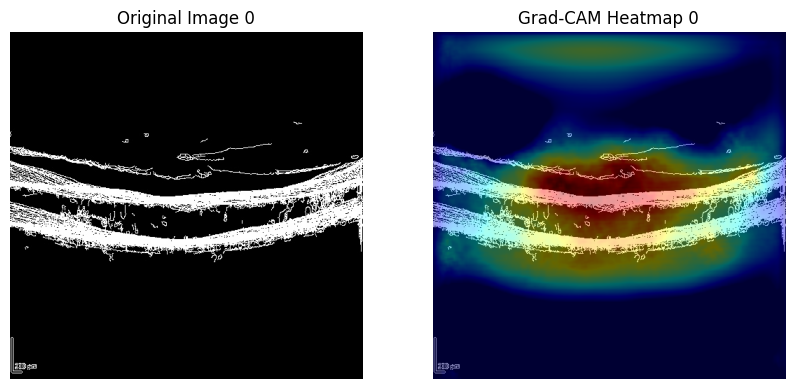

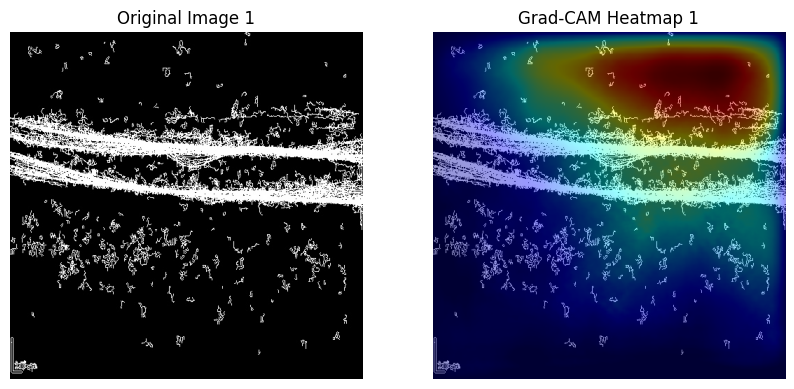

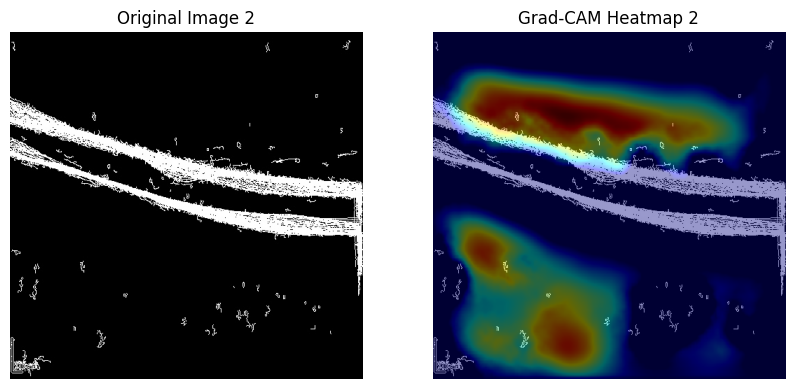

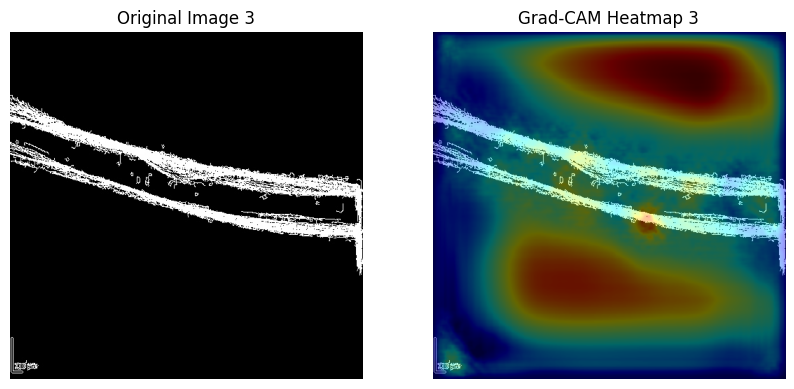

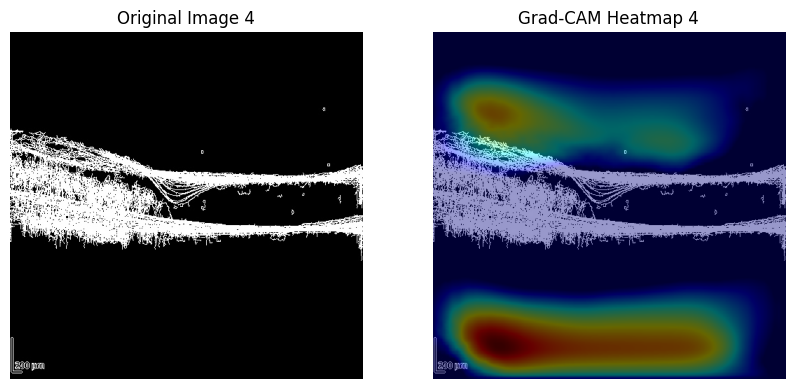

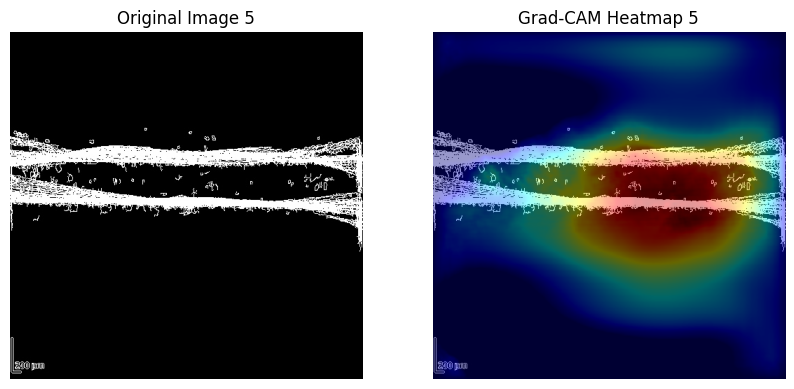

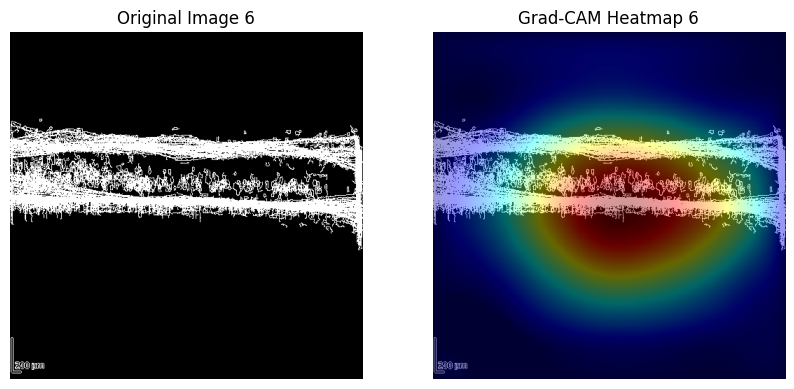

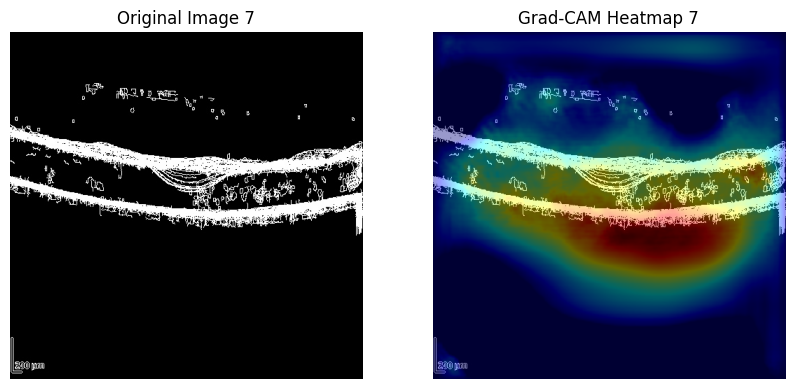

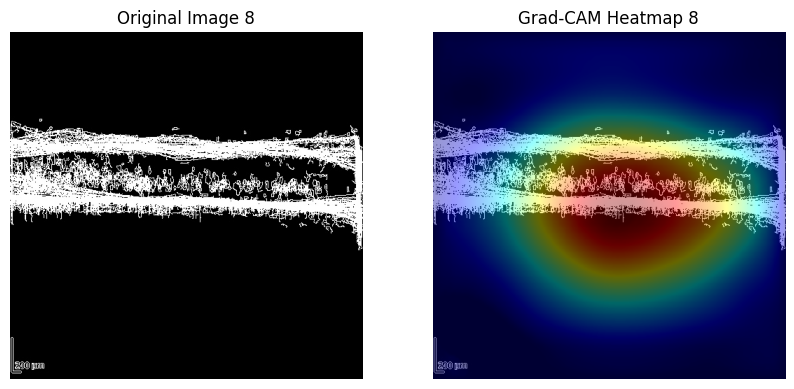

In [40]:
#Heat-map generation based on explainability assignment
import torch.nn.functional as F
import matplotlib.pyplot as plt

def grad_cam(device, model, input_image_path, target_layer):
    model.eval()

    # transforms
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = cv2.imread(input_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    img_pil = Image.fromarray(img)  # Convert NumPy array to PIL Image
    input_tensor = preprocess(img_pil).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    # Forward and backward hooks
    feature_maps = []
    gradients = []

    def forward_hook(_, input, output):
        feature_maps.append(output)

    def backward_hook(_, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.zero_grad()
    output = model(input_tensor)

    # Backward pass
    target_class = output.argmax(1).item()
    output[:, target_class].backward()

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    # Grad-CAM computation
    feature_map = feature_maps[0].detach()
    gradient = gradients[0].detach()
    weights = F.adaptive_avg_pool2d(gradient, 1)

    grad_cam_map = torch.mul(feature_map, weights).sum(dim=1, keepdim=True).relu()
    grad_cam_map = F.interpolate(grad_cam_map, (224, 224), mode='bilinear', align_corners=False).squeeze().cpu().numpy()

    # Normalize the heatmap
    grad_cam_map = grad_cam_map - np.min(grad_cam_map)
    grad_cam_map = grad_cam_map / np.max(grad_cam_map)

    return grad_cam_map

#Image list containing images from each DRSS severity category
input_image_list = []
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-027/W52/OS/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/02-031/W100/OD/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-002/W40/OD/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-002/W4/OD/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-013/W92/OD/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-026/W92/OD/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-026/W0/OD/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-020/W0/OS/cn_final.jpg")
input_image_list.append("/content/drive/MyDrive/FML_Project/Prime_FULL/01-026/W0/OD/cn_final.jpg")

#Iterates over list of images
for idx, input_image in enumerate(input_image_list):
    # Create heat-map for every image
    heatmap = grad_cam(device, model, input_image, model.unet.decoder.blocks[4].conv2)

    # Combine image with heatmap
    img = cv2.imread(input_image)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Write original image and corresponding grad cam heatmap
    original_image_output_path = f"{idx}_original_image.jpg"
    superimposed_image_output_path = f"{idx}_grad_cam_heatmap.jpg"
    cv2.imwrite(original_image_output_path, img)
    cv2.imwrite(superimposed_image_output_path, superimposed_img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {idx}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Grad-CAM Heatmap {idx}')
    plt.axis('off')

    plt.show()

In [42]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
#Print the model summary - each layer within the model
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
          Identity-2         [-1, 64, 112, 112]               0
             Swish-3         [-1, 64, 112, 112]               0
    BatchNormAct2d-4         [-1, 64, 112, 112]             128
            Conv2d-5         [-1, 64, 112, 112]             576
          Identity-6         [-1, 64, 112, 112]               0
             Swish-7         [-1, 64, 112, 112]               0
    BatchNormAct2d-8         [-1, 64, 112, 112]             128
            Conv2d-9             [-1, 16, 1, 1]           1,040
            Swish-10             [-1, 16, 1, 1]               0
           Conv2d-11             [-1, 64, 1, 1]           1,088
          Sigmoid-12             [-1, 64, 1, 1]               0
    SqueezeExcite-13         [-1, 64, 112, 112]               0
           Conv2d-14         [-1, 32, 1